# Modelo de Lead Scoring

En este notebook iremos desarrollando las tareas necesarias para construir un modelo de lead scoring comenzando desde la ingesta de datos

## 1. Data analysis

Importamos todas las librerias necesarias y consumimos los datos

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam


warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
sns.set(rc={'figure.figsize':(11.7,11.7)})
pd.options.display.max_columns = None
data = pd.read_csv('./leads/Leads.csv')

### 1.1 Data Cleaning

En esta etapa nos familiarizamos con los datos e intentamos entender que tipo de informacion aporta cada variable. De aqui surgiran hipotesis respecto a que variables son mas relevantes y que tipo de limpieza/curacion sera necesaria

Empezamos desplegando las primeras 5 filas para entender que cosas trae

In [2]:
data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [3]:
data.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


Notamos:

- Hay algunos campos con valores nulos
- Hay un campo "booleano" (converted), que es el que probablemente querramos predecir
- Empezamos a intuir los valores que puede tomar cada columna

Ahora nos falta entender mejor los campos no numericos


In [4]:
data.describe(include=[object])

,Prospect ID,Lead Origin,Lead Source,Do Not Email,Do Not Call,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
count,9240,9240,9204,9240,9240,9137,6779,7802,7033,6550,6531,9240,9240,9240,9240,9240,9240,9240,9240,5887,4473,9240,9240,6531,7820,5022,5022,9240,9240,9240
unique,9240,5,21,2,2,17,38,19,10,6,3,2,1,2,2,2,2,2,1,26,5,1,1,6,7,3,3,1,2,16
top,0291bfdf-ba18-4877-b9f6-fb3122af852b,Landing Page Submission,Google,No,No,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,02.Medium,No,No,Modified
freq,1,4886,2868,8506,9238,3437,6492,1942,5043,5600,6528,9226,9240,9238,9239,9239,9236,9233,9240,2072,1560,9240,9240,4146,3222,3839,2788,9240,6352,3407


Notamos:

- Hay campos identificadores que podriamos excluir del modelo (`prospect id`, `lead Number`)
- Hay campos que unicamente tienen un valor (`Magazine` ,`I agree to pay the amount through cheque`, `Receive more updates` , etc) que podriamos excluir por no agregar info
- Hay algunos campos que podriamos procesar un poco para que representen mejor su informacion (Campos de `Asymmetrique`)
- Hay mas campos "booleanos" codificados como texto (`Do not Email`, `Do not call`)

Ya que notamos que hay valores nulos, veamos cuantos hay en cada columna


In [5]:
data.isnull().sum()

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   1438
How did you hear about X Education               2207
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article           

Vemos que hay muchas columnas con valores nulos. Y muchos de ellas con casi el 50% de sus valores asi. Vamos a deshacernos de ellas y de las otras columnas que identificamos y a convertir las columnas booleanas a numerica


In [6]:
data = data.dropna(axis=1)
data = data.drop(columns=['Prospect ID', 'Lead Number', 'I agree to pay the amount through cheque', 'Magazine', 'Receive More Updates About Our Courses', 
                          'Update me on Supply Chain Content', 'Get updates on DM Content' ])
string_to_boolean_map = {"Yes": 1, "No": 0}
for column in data.columns:
    if 'Yes' in data[column].values and 'No' in data[column].values:
        data[column] = data[column].map(string_to_boolean_map)


In [7]:
data

,Lead Origin,Do Not Email,Do Not Call,Converted,Total Time Spent on Website,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,A free copy of Mastering The Interview,Last Notable Activity
0,API,0,0,0,0,0,0,0,0,0,0,0,Modified
1,API,0,0,0,674,0,0,0,0,0,0,0,Email Opened
2,Landing Page Submission,0,0,1,1532,0,0,0,0,0,0,1,Email Opened
3,Landing Page Submission,0,0,0,305,0,0,0,0,0,0,0,Modified
4,Landing Page Submission,0,0,1,1428,0,0,0,0,0,0,0,Modified
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,Landing Page Submission,1,0,1,1845,0,0,0,0,0,0,0,Email Marked Spam
9236,Landing Page Submission,0,0,0,238,0,0,0,0,0,0,1,SMS Sent
9237,Landing Page Submission,1,0,0,199,0,0,0,0,0,0,1,SMS Sent
9238,Landing Page Submission,0,0,1,499,0,0,0,0,0,0,0,SMS Sent


Luego de haber *limpiado* nuestros datos, estamos en conndiciones de comenzar la **exploracion** en busqueda de relaciones interesantes entre nuestras variables

### 1.2 Exploratory Analysis

Comenzamos graficando algunas de las variables respecto a nuestra variable **a predecir**

<AxesSubplot:xlabel='Lead Origin', ylabel='Converted'>

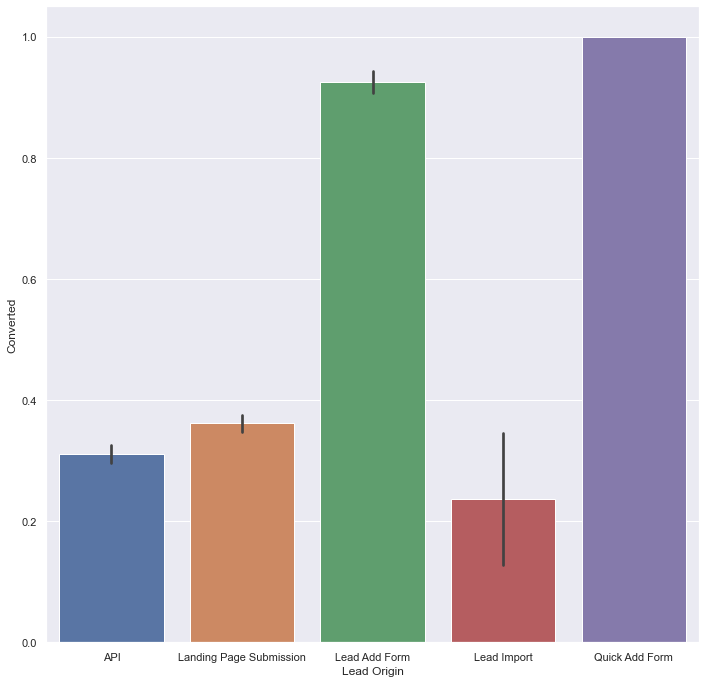

In [8]:
sns.barplot(data=data, y='Converted', x='Lead Origin')

<AxesSubplot:xlabel='Do Not Email', ylabel='Converted'>

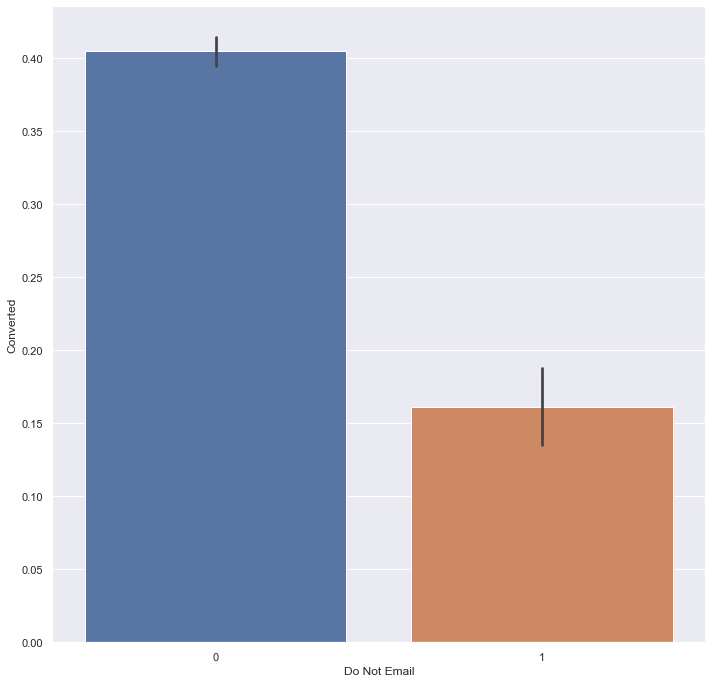

In [9]:
sns.barplot(data=data, y='Converted', x='Do Not Email')

<AxesSubplot:xlabel='Search', ylabel='Converted'>

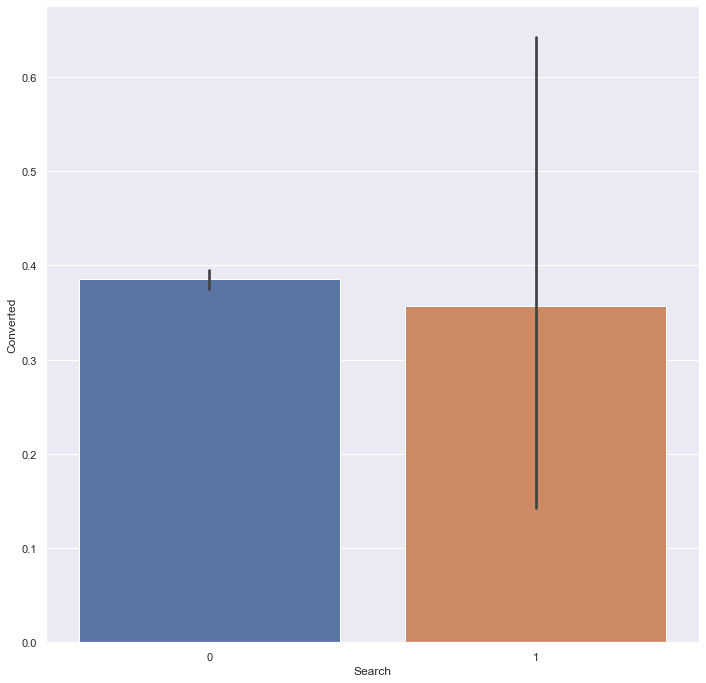

In [10]:
sns.barplot(data=data, y='Converted', x='Search')

<AxesSubplot:xlabel='Last Notable Activity', ylabel='Converted'>

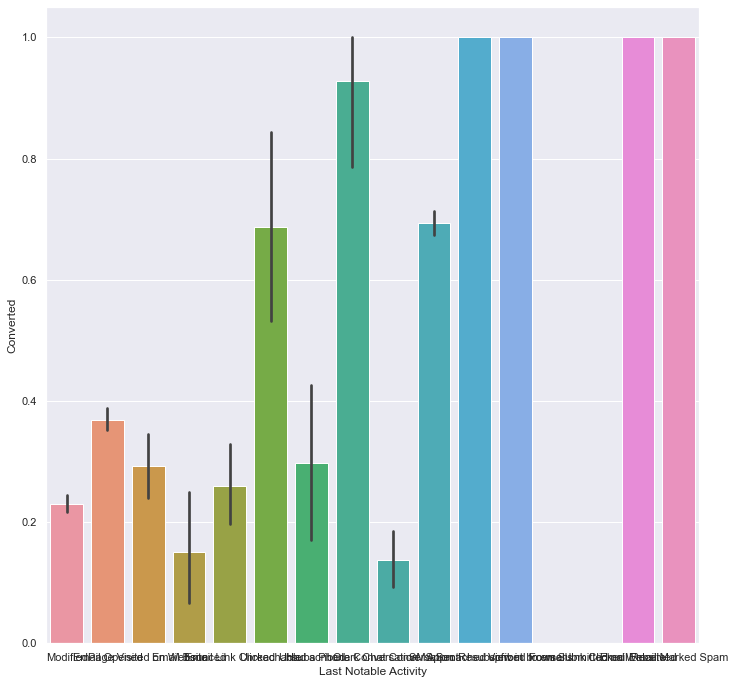

In [11]:
sns.barplot(data=data, y='Converted', x='Last Notable Activity')

<AxesSubplot:xlabel='Total Time Spent on Website', ylabel='Count'>

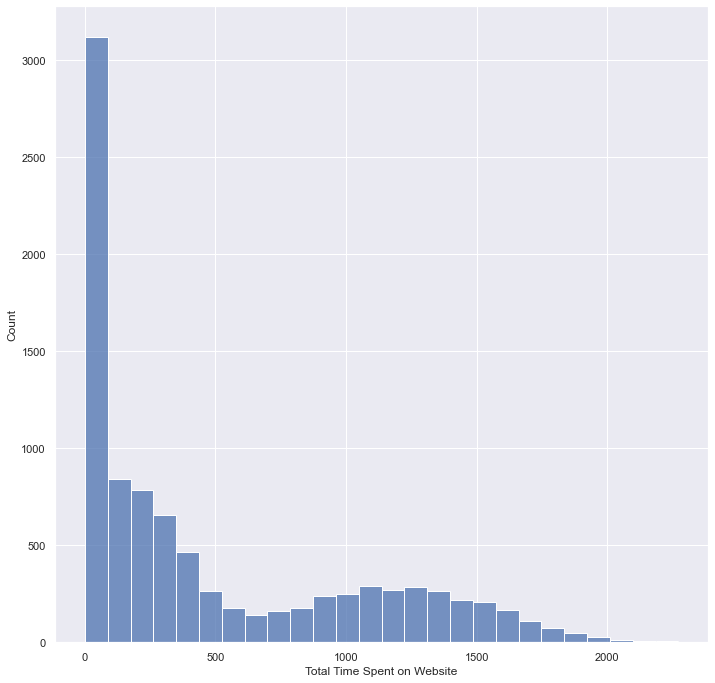

In [12]:
sns.histplot(data=data, x='Total Time Spent on Website')

## 2. Model Building

Ahora que hemos explorado los datos y tenemos una mejor idea de como se relacionan con la variable a predecir, comenzaremos a construir modelos tentativos para predecir la conversion

Comenzamos dandole un ultimo pre-procesamiento a nuestros datos antes de que puedan usarse de input para los modelos. Hay que convertir las variables categoricas (`Last Notable Activity` y `Lead Origin`) a algo sobre lo que se pueda operar matematicamente. Utilizaremos **one-hot encoding** para lograrlo. Pandas provee una forma sencilla de aplicar esta transformacion


In [13]:
one_hot_encoded_variables = pd.get_dummies(data[['Lead Origin', 'Last Notable Activity']], drop_first=True)
data = pd.concat([data, one_hot_encoded_variables], axis=1)
data = data.drop(['Lead Origin', 'Last Notable Activity'], axis=1)

In [14]:
one_hot_encoded_variables


,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9236,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9237,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9238,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### 2.1 Creacion de datasets de entrenamiento y de prueba

Ahora debemos separar la **variable a predecir** del resto de los **predictores**, asi como separar nuestros datos en datasets de **entrenamiento** y **prueba** 

In [15]:
predictors = data.drop(['Converted'], axis=1)
to_predict = data['Converted'] 
X_train, X_test, y_train, y_test = train_test_split(predictors, to_predict, train_size=0.8, test_size=0.2)

### 2.2 Feature Scaling

Todas las variables predictoras, a excepcion del tiempo total de visita al sitio web, son booleanas (sus valores pueden ser 0 o 1). Para que el modelo no se sesgue con esa otra variable, conviene aplicar algun tipo de escalado (en nuestro caso, **estandarizacion**) sobre esa variable para convertir sus valores a una unidad "estandar" compartida por todas las demas (en este caso, la "desviacion estandar")


In [16]:
scaler = StandardScaler()
X_train['Total Time Spent on Website'] = scaler.fit_transform(X_train[['Total Time Spent on Website']])
X_test['Total Time Spent on Website'] = scaler.fit_transform(X_test[['Total Time Spent on Website']])

In [17]:
X_train

,Do Not Email,Do Not Call,Total Time Spent on Website,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
8001,0,0,-0.364199,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,0,0,-0.756025,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8268,0,0,0.536091,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8468,1,0,-0.690417,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6994,0,0,1.638671,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4221,0,0,1.487408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
758,0,0,-0.699529,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4525,0,0,2.214565,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4016,0,0,1.450959,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2.3 Model Fitting

En esta etapa entrenaremos los diferentes modelos que creemos mas adecuados para el problema



In [18]:
from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression().fit(X_train, y_train)


### 2.4 Evaluacion de la calidad del modelo

La calidad de la estimacion en el dataset de **prueba** es


In [19]:
logistic_regression_model.score(X_test, y_test)


0.7635281385281385

Y en el de **entrenamiento**

In [20]:
logistic_regression_model.score(X_train, y_train)

0.784767316017316

Realizamos la **matriz de confusion** y obtenemos las metricas asociadas a estos valores

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1106
           1       0.76      0.60      0.67       742

    accuracy                           0.76      1848
   macro avg       0.76      0.74      0.74      1848
weighted avg       0.76      0.76      0.76      1848



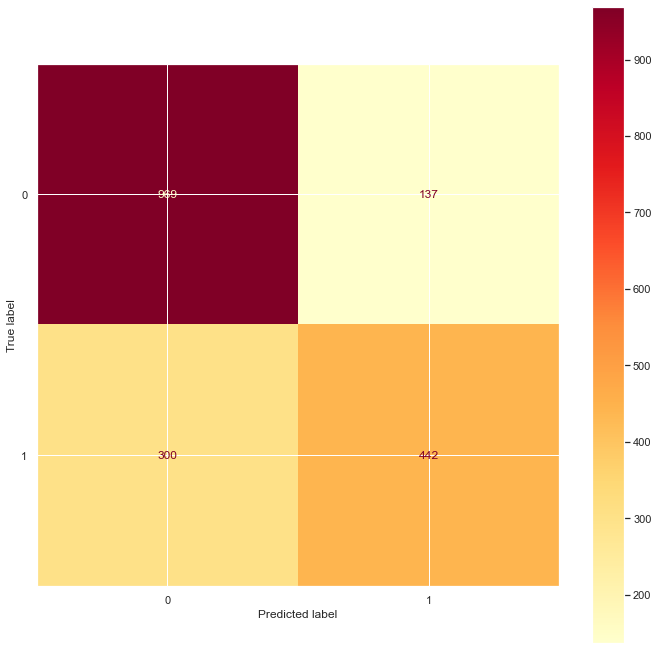

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(y_test, logistic_regression_model.predict(X_test))).plot(cmap="YlOrRd")
print(classification_report(y_test, logistic_regression_model.predict(X_test)))

## Probando una Red neuronal

Como modelo competidor, probamos entenar una red neuronal (Perceptron multicapa) y evaluamos su desempeno respecto a la regresion logistica

In [22]:
formatted_data = X_train.values
dimensions = formatted_data.shape

adam_optimizer = Adam(learning_rate=0.01)
neural_net = Sequential()
neural_net.add(Dense(128, input_dim=dimensions[1], activation='tanh'))
neural_net.add(Dense(256, input_dim=dimensions[1], activation='tanh'))
neural_net.add(Dense(128, input_dim=dimensions[1], activation='tanh'))
neural_net.add(Dense(1, activation='sigmoid'))
neural_net.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
neural_net.fit(formatted_data, y_train.values, epochs=100, batch_size=1000, validation_split=0.2)


Epoch 1/100
6/6 [==============================] - 11s 100ms/step - loss: 0.6812 - accuracy: 0.5878 - val_loss: 0.4490 - val_accuracy: 0.7965
Epoch 2/100
6/6 [==============================] - 0s 15ms/step - loss: 0.4762 - accuracy: 0.7797 - val_loss: 0.4589 - val_accuracy: 0.8080
Epoch 3/100
6/6 [==============================] - 0s 13ms/step - loss: 0.4535 - accuracy: 0.8035 - val_loss: 0.4414 - val_accuracy: 0.8087
Epoch 4/100
6/6 [==============================] - 0s 16ms/step - loss: 0.4495 - accuracy: 0.7958 - val_loss: 0.4374 - val_accuracy: 0.8100
Epoch 5/100
6/6 [==============================] - 0s 15ms/step - loss: 0.4471 - accuracy: 0.8066 - val_loss: 0.4367 - val_accuracy: 0.8168
Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 0.4482 - accuracy: 0.8009 - val_loss: 0.4314 - val_accuracy: 0.8087
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 0.4325 - accuracy: 0.8069 - val_loss: 0.4302 - val_accuracy: 0.8147
Epoch 8/100
6/6 [=

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1106
           1       0.76      0.74      0.75       742

    accuracy                           0.80      1848
   macro avg       0.79      0.79      0.79      1848
weighted avg       0.80      0.80      0.80      1848



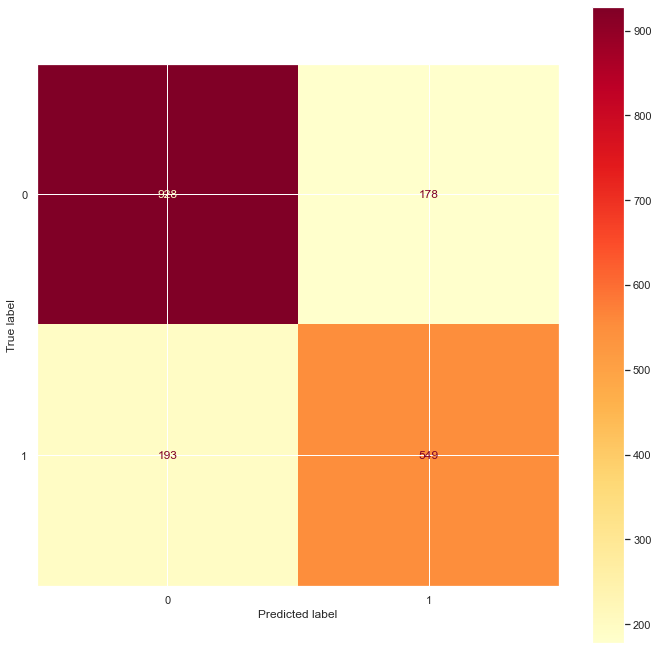

In [23]:
ConfusionMatrixDisplay(confusion_matrix(y_test.values, neural_net.predict_classes(X_test.values))).plot(cmap="YlOrRd")
print(classification_report(y_test.values, neural_net.predict_classes(X_test.values)))

## Exploramos los resultados

Ahora nos creamos una tabla para mirar algunos resultados y entender que probabilidad de convertir le asigno uno u otro modelo, comparado con lo que verdaderamente ocurrio en el set de prueba (un conjunto de datos que nunca vieron ninguno de los modelos durante el entrenamiento)

In [28]:
neural_net_raw_predictions = neural_net.predict(X_test.values).squeeze()
logistic_regression_raw_predictions = list(map(lambda x: x[1], logistic_regression_model.predict_proba(X_test)))
predictions_table = pd.DataFrame({"real": y_test.values, "log_reg": logistic_regression_raw_predictions , "neural_net": neural_net_raw_predictions })
predictions_table.head(50)

,real,log_reg,neural_net
0,1,0.877857,0.840203
1,0,0.100004,0.082690
2,0,0.259169,0.171829
3,1,0.253258,0.184913
4,1,0.235855,0.083995
5,0,0.183995,0.273864
6,0,0.100004,0.082690
7,1,0.809217,0.859845
8,0,0.183995,0.273864
9,0,0.100004,0.082690


array([[0.12214273, 0.87785727],
       [0.89999583, 0.10000417],
       [0.74083131, 0.25916869],
       ...,
       [0.37433815, 0.62566185],
       [0.64053374, 0.35946626],
       [0.14357115, 0.85642885]])